In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import necessary files (NER, RE)**

**+ folder/file (name and source in our case, change the names and paths according to your case)**
+ OpenNRE instalation folder (OpenNRE from Google drive)
+ pretrained BioBERT folder (biobert_v1.1_pubmed from Google Drive)
+ NER tags file (ner_tags.csv)
+ Disease train set for NER (disease_train_set.csv)
+ Disease test set for NER (disease_test_set.csv)
+ Drug train set for NER (drug_train_set.csv)
+ Drug test set for NER (drug_test_set.csv)
+ Cell train set for NER (cell_train_set.csv)
+ Cell test set for NER (cell_test_set.csv)
+ Gene train set for NER (gene_train_set.csv)
+ Gene test set for NER (gene_test_set.csv)

# **Install packages**

Install standard packages with pip

In [ ]:
!pip install pytorch-pretrained-bert
!pip install transformers
!pip install keras_preprocessing
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
!pip install -U pytest
!pip install -U scikit-learn
!pip install scipy
!pip install nltk
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_sm-0.4.0.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 110.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.3 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 102.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 24.1 MB/s eta 0:00:00
  Preparing metadata (setup.py)

Install OpenNRE from source

# **Import packages**

In [ ]:
import os
import re
import csv
import itertools

import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from collections import defaultdict, OrderedDict

import multiprocessing
from multiprocessing import Pool, cpu_count
cores = multiprocessing.cpu_count()
from tqdm.contrib.concurrent import process_map

import glob
import collections

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from pytorch_pretrained_bert import BertModel, BertTokenizer, BertConfig
from transformers import BertForTokenClassification, AdamW
from transformers import get_linear_schedule_with_warmup

import tensorflow as tf
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import csv

import json
import sys
import argparse
import logging
import random

import unittest
import nltk
nltk.download('punkt')
from operator import add

import spacy
from spacy.language import Language
from scispacy.umls_linking import UmlsEntityLinker

import networkx as nx

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **Pipeline input text**

In [ ]:
#text = """an inhibitor of folate metabolism , amethopterin ( methotrexate ) has been successfully used in the treatment of psoriasis and neoplastic disease . thrombolytics , administered as a bolus of urokinase ( 15000 cta u/kg ) , are indicated in cases of life-threatening pulmonary emboli , those with a pulmonary vascular obstruction of more than 50 % and with hypotension , shock , or acute right ventricular failure . although a single , 2-gm dose of metronidazole has been approved for the treatment of vaginal trichomoniasis , this regimen has not gained general acceptance . events in the year before the first signs of disease onset were investigated in 30 consecutive patients with cushing's syndrome ( 26 with a pituitary-dependent form , three with an adrenal adenoma , and one with an adrenal carcinoma ) and 30 control subjects matched for sociodemographic variables by means of paykel 's interview for recent life events ."""
text =''
with open('cord19_text.txt') as f:
 text1 = f.read()

text = text + ' ' + text1
print(text)

 life expectancy increased globally past centuries years decades years . recent phenomenon emerged consequence improvements nutrition hygiene antimicrobial therapy vaccinations . development antiviral therapy lagged . elderly respiratory viral infections cause significant morbidity mortality nonpneumonic lower respiratory illnesses linked respiratory viral infection usa estimated annual deaths attributed influenza respiratory syncytial viruses rsv . milestone diagnostics respiratory viral infections discovery influenza virus . discovery coronaviruses new respiratory viruses significant virus strains identified years . development polymerase chain reaction pcr techniques 1990s initiated new wave viral diagnostics . avian flu epidemic humans caused influenza virus h5n1 struck alerted healthcare professionals severity . year virus family seen humans identified anellovirus torque teno virus ttv signature virus found link human illnesses address correspondence department pediatrics turku un

# **NER**

In [ ]:
# Get GPU device name
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
else:
  raise SystemError('GPU device not found')

# tell Pytorch to use the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('There are %d GPU(s) available.' % torch.cuda.device_count())
print('We will use the GPU:', torch.cuda.get_device_name(0))

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!transformers-cli convert --model_type bert --tf_checkpoint /content/drive/MyDrive/biobert_v1.1_pubmed/model.ckpt-1000000 --config /content/drive/MyDrive/biobert_v1.1_pubmed/bert_config.json --pytorch_dump_output /content/pytorch_model.bin

2023-12-07 08:42:27.717314: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 08:42:27.717365: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 08:42:27.717403: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 08:42:28.952271: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Building PyTorch model from configuration: BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inter

In [ ]:
MAX_LEN = 75
BATCH_SIZE = 32
tokenizer = BertTokenizer(vocab_file='/content/drive/MyDrive/biobert_v1.1_pubmed/vocab.txt', do_lower_case=False)

In [ ]:
class BioBertNER(nn.Module):

  def __init__(self, vocab_len, config, state_dict):
    super().__init__()
    self.bert = BertModel(config)
    self.bert.load_state_dict(state_dict, strict=False)
    self.dropout = nn.Dropout(p=0.3)
    self.output = nn.Linear(self.bert.config.hidden_size, vocab_len)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask):
    encoded_layer, _ = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    encl = encoded_layer[-1]
    out = self.dropout(encl)
    out = self.output(out)
    return out, out.argmax(-1)

In [ ]:
class SentenceFetch(object):

  def __init__(self, data):
    self.data = data
    self.sentences = []
    self.tags = []
    self.sent = []
    self.tag = []

    # make tsv file readable
    with open(self.data) as tsv_f:
      csv.field_size_limit(sys.maxsize)
      if'.csv' in str(data):
        reader = csv.reader(tsv_f, delimiter=';')
      if'.tsv' in str(data):
        reader = csv.reader(tsv_f, delimiter='\t')
      for row in reader:
        if len(row) == 0:
          if len(self.sent) != len(self.tag):
            break
          self.sentences.append(self.sent)
          self.tags.append(self.tag)
          self.sent = []
          self.tag = []
        else:
          self.sent.append(row[0])
          self.tag.append(row[1])

  def getSentences(self):
    return self.sentences

  def getTags(self):
    return self.tags

In [ ]:
class Enti:

  def __new__(cls, *args, **kwargs):
        return super().__new__(cls)
  def __init__(self,a,b,c):
    self.name = a
    self.pos = b
    self.classe = c
    self.cui = ''
    self.umls_label = ''
  def __repr__(self):
    return f'{self.pos} {self.classe}'
  def tojson(self):
    return {
        'name': self.name,
        'start': self.pos[0],
        'end': self.pos[1],
        'label': self.classe,
        'cui': self.cui,
        'umls_label': self.umls_label
    }

In [ ]:
ner_tags = '/content/ner_tags.csv'
data = pd.read_csv(ner_tags)
tag_values = data['tags'].values
vocab_len = len(tag_values)
print('Entity Types:',vocab_len)

df_tags = pd.DataFrame({'tags':tag_values})
df_tags.to_csv(ner_tags,index=False)
df = pd.read_csv(ner_tags)
print('Tag Preview:\n', df)

Entity Types: 9
Tag Preview:
                      tags
0                       O
1               B-Disease
2               I-Disease
3                  B-Drug
4                  B-Cell
5                  I-Cell
6  B-Gene_or_gene_product
7  I-Gene_or_gene_product
8                     PAD


In [ ]:
def get_entities(ner_train_file, ner_test_file):

#  data = pd.read_csv(ner_tags_file)
#  tag_values = data['tags'].values
#  vocab_len = len(tag_values)
#  print('Entity Types:',vocab_len)

#  df_tags = pd.DataFrame({'tags':tag_values})
#  df_tags.to_csv(ner_tags_file,index=False)
#  df = pd.read_csv(ner_tags_file)
#  print('Tag Preview:\n', df)

  sentences = []
  tags = []
  path = os.path.join(ner_train_file)
  sent = SentenceFetch(path).getSentences()
  tag = SentenceFetch(path).getTags()
  sentences.extend(sent)
  tags.extend(tag)

  sentences2 = []
  tags2 = []

  path2 = os.path.join(ner_test_file)
  sent2 = SentenceFetch(path2).getSentences()
  tag2 = SentenceFetch(path).getTags()
  sentences2.extend(sent2)
  tags2.extend(tag2)

  def tok_with_labels(sent, text_labels):
    '''tokenize and keep labels intact'''
    tok_sent = []
    labels = []
    for word, label in zip(sent, text_labels):
      tok_word = tokenizer.tokenize(word)
      n_subwords = len(tok_word)

      tok_sent.extend(tok_word)
      labels.extend([label] * n_subwords)
    return tok_sent, labels

  tok_texts_and_labels = [tok_with_labels(sent, labs) for sent, labs in zip(sentences, tags)]
  #--------
  tok_texts = [tok_label_pair[0] for tok_label_pair in tok_texts_and_labels]
  labels = [tok_label_pair[1] for tok_label_pair in tok_texts_and_labels]
  #--------
  input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tok_texts],
                            maxlen=MAX_LEN, dtype="long", value=0.0,
                            truncating="post", padding="post")

  #--------
  tag_values = list(set(itertools.chain.from_iterable(tags)))
  tag_values.append("PAD")

  tag2idx = {t: i for i,t in enumerate(tag_values)}
  #--------
  tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                      maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                      dtype="long", truncating="post")
  #--------
  # attention masks make explicit reference to which tokens are actual words vs padded words
  attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]
  #--------

  tr_inputs = input_ids
  tr_tags = tags
  tr_masks = attention_masks

  tok_texts_and_labels2 = [tok_with_labels(sent, labs) for sent, labs in zip(sentences2, tags2)]
  #--------
  tok_texts2 = [tok_label_pair[0] for tok_label_pair in tok_texts_and_labels2]
  labels2 = [tok_label_pair[1] for tok_label_pair in tok_texts_and_labels2]
  #--------
  input_ids2 = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tok_texts2],
                            maxlen=MAX_LEN, dtype="long", value=0.0,
                            truncating="post", padding="post")
  #--------
  tag_values2 = list(set(itertools.chain.from_iterable(tags2)))
  tag_values2.append("PAD")

  tag2idx2 = {t: i for i,t in enumerate(tag_values2)}
  #--------
  tags2 = pad_sequences([[tag2idx2.get(l) for l in lab] for lab in labels2],
                      maxlen=MAX_LEN, value=tag2idx2["PAD"], padding="post",
                      dtype="long", truncating="post")
  #--------
  # attention masks make explicit reference to which tokens are actual words vs padded words
  attention_masks2 = [[float(i != 0.0) for i in ii] for ii in input_ids2]
  #--------

  val_inputs = input_ids2
  val_tags = tags2
  val_masks = attention_masks2

  tr_inputs = torch.tensor(tr_inputs)
  val_inputs = torch.tensor(val_inputs)
  tr_tags = torch.tensor(tr_tags)
  val_tags = torch.tensor(val_tags)
  tr_masks = torch.tensor(tr_masks)
  val_masks = torch.tensor(val_masks)

  train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

  valid_data = TensorDataset(val_inputs, val_masks, val_tags)
  valid_sampler = SequentialSampler(valid_data)
  valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

  config = BertConfig.from_json_file('/content/drive/MyDrive/biobert_v1.1_pubmed/bert_config.json')
  tmp_d = torch.load('/content/pytorch_model.bin', map_location=device)
  state_dict = OrderedDict()

  for i in list(tmp_d.keys())[:199]:
      x = i
      if i.find('bert') > -1:
          x = '.'.join(i.split('.')[1:])
      state_dict[x] = tmp_d[i]

  model = BioBertNER(vocab_len,config,state_dict)
  model.to(device)

  param_optimizer = list(model.named_parameters())
  no_decay = ['bias', 'gamma', 'beta']
  optimizer_grouped_parameters = [
          {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
          'weight_decay_rate': 0.01},
          {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
          'weight_decay_rate': 0.0}
      ]

  optimizer = AdamW(
      optimizer_grouped_parameters,
      lr=3e-5,
      eps=1e-8
  )
  epochs = 3
  max_grad_norm = 1.0

  total_steps = len(train_dataloader) * epochs

  scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=0,
      num_training_steps=total_steps
  )
  loss_fn = nn.CrossEntropyLoss().to(device)

  def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler):
      model = model.train()
      losses = []
      correct_predictions = 0
      for step,batch in enumerate(data_loader):
          batch = tuple(t.to(device) for t in batch)
          b_input_ids, b_input_mask, b_labels = batch
          outputs,y_hat = model(b_input_ids,b_input_mask)

          _,preds = torch.max(outputs,dim=2)
          outputs = outputs.view(-1,outputs.shape[-1])
          b_labels_shaped = b_labels.view(-1)
          loss = loss_fn(outputs,b_labels_shaped)
          correct_predictions += torch.sum(preds == b_labels)
          losses.append(loss.item())

          loss.backward()
          torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
          optimizer.step()
          scheduler.step()
          optimizer.zero_grad()

      return correct_predictions.double()/len(data_loader) , np.mean(losses)

  def model_eval(model,data_loader,loss_fn,device):
      model = model.eval()

      losses = []
      correct_predictions = 0

      with torch.no_grad():
          for step, batch in enumerate(data_loader):
              batch = tuple(t.to(device) for t in batch)
              b_input_ids, b_input_mask, b_labels = batch

              outputs,y_hat = model(b_input_ids,b_input_mask)

              _,preds = torch.max(outputs,dim=2)
              outputs = outputs.view(-1,outputs.shape[-1])
              b_labels_shaped = b_labels.view(-1)
              loss = loss_fn(outputs,b_labels_shaped)
              correct_predictions += torch.sum(preds == b_labels)
              losses.append(loss.item())


      return correct_predictions.double()/len(data_loader) , np.mean(losses)

  #%%time
  history = defaultdict(list)
  best_accuracy = 0
  normalizer = BATCH_SIZE*MAX_LEN
  loss_values = []

  for epoch in range(epochs):

      total_loss = 0
      print(f'======== Epoch {epoch+1}/{epochs} ========')
      train_acc,train_loss = train_epoch(model,train_dataloader,loss_fn,optimizer,device,scheduler)
      train_acc = train_acc/normalizer
      print(f'Train Loss: {train_loss} Train Accuracy: {train_acc}')
      total_loss += train_loss.item()

      avg_train_loss = total_loss / len(train_dataloader)
      loss_values.append(avg_train_loss)

      val_acc,val_loss = model_eval(model,valid_dataloader,loss_fn,device)
      val_acc = val_acc/normalizer
      print(f'Val Loss: {val_loss} Val Accuracy: {val_acc}')

      history['train_loss'].append(train_loss)
      history['train_acc'].append(train_acc)

      history['val_loss'].append(val_loss)
      history['val_acc'].append(val_acc)

  sns.set(style='darkgrid')

  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)

  # learning curve
  plt.plot(loss_values, 'b-o')

  plt.title("Training loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.show()

  sent_text = nltk.sent_tokenize(text)

  tokenized_text = []
  for sentence in sent_text:
      tokenized_text.append(nltk.word_tokenize(sentence))

  def tokenize_and_preserve(sentence):
      tokenized_sentence = []

      for word in sentence:
          tokenized_word = tokenizer.tokenize(word)
          tokenized_sentence.extend(tokenized_word)

      return tokenized_sentence

  tok_texts = [
      tokenize_and_preserve(sent) for sent in tokenized_text
  ]

  input_ids = [tokenizer.convert_tokens_to_ids(txt) for txt in tok_texts]
  input_attentions = [[1]*len(in_id) for in_id in input_ids]

  tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
  new_tokens, new_labels = [], []
  for token in tokens:
      if token.startswith("##"):
          new_tokens[-1] = new_tokens[-1] + token[2:]
      else:

          new_tokens.append(token)

  actual_sentences = []
  pred_labels = []
  for x,y in zip(input_ids,input_attentions):
      x = torch.tensor(x).cuda()
      y = torch.tensor(y).cuda()
      x = x.view(-1,x.size()[-1])
      y = y.view(-1,y.size()[-1])
      with torch.no_grad():
          _,y_hat = model(x,y)
      label_indices = y_hat.to('cpu').numpy()

      tokens = tokenizer.convert_ids_to_tokens(x.to('cpu').numpy()[0])
      new_tokens, new_labels = [], []
      for token, label_idx in zip(tokens, label_indices[0]):
          if token.startswith("##"):
              new_tokens[-1] = new_tokens[-1] + token[2:]
          else:
              new_labels.append(tag_values[label_idx])
              new_tokens.append(token)
      actual_sentences.append(new_tokens)
      pred_labels.append(new_labels)

  positions = []

  for a in range(len(actual_sentences)):
    pos = []
    pos.append([0,len(actual_sentences[a][0])])
    for i in range(1,len(actual_sentences[a])):
      le=0
      for j in range(i):
        le = le + len(actual_sentences[a][j])
      le = le + sent_text[a][0:pos[-1][1]+1].count(' ')
      pos.append([le,le+len(actual_sentences[a][i])])
    positions.append(pos)

  ents = []
  for x in range(len(actual_sentences)):
    eent = []
    for i in range(len(actual_sentences[x])):
      if (pred_labels[x][i] != 'O') and (pred_labels[x][i] != 'PAD'):
        eent.append(Enti(actual_sentences[x][i],positions[x][i],pred_labels[x][i]).tojson())
    ents.append(eent)

  return ents

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


======== Epoch 1/3 ========
Train Loss: 0.14019209175673594 Train Accuracy: 0.9497138554216868
Val Loss: 0.4855166814829174 Val Accuracy: 0.8999342105263158
======== Epoch 2/3 ========
Train Loss: 0.017159567388470274 Train Accuracy: 0.9907279116465866
Val Loss: 0.489139514534097 Val Accuracy: 0.9016008771929825
======== Epoch 3/3 ========
Train Loss: 0.010717578277171376 Train Accuracy: 0.9927108433734941
Val Loss: 0.55135556898619 Val Accuracy: 0.9020833333333333


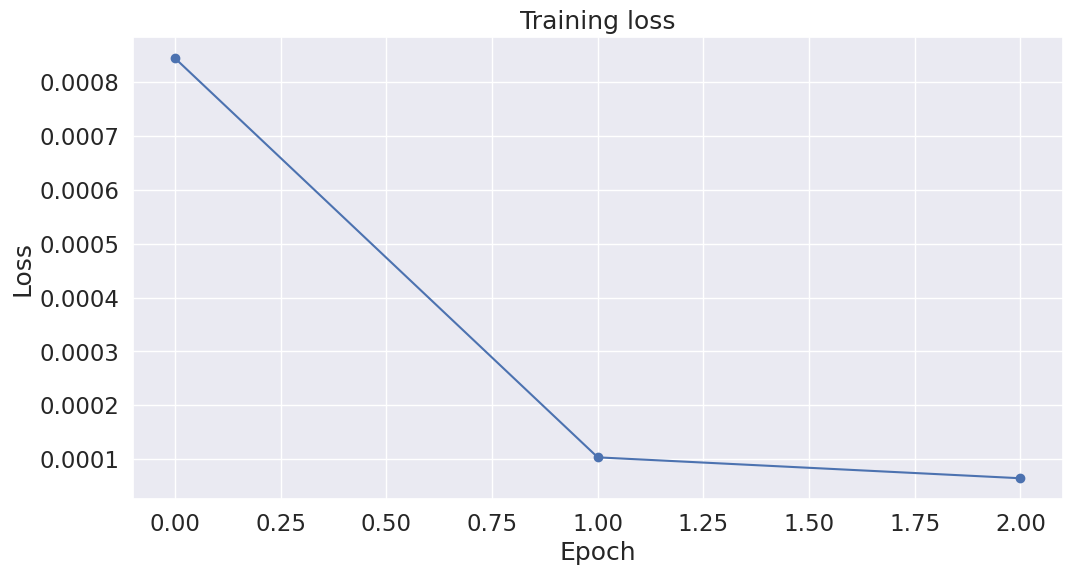

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


======== Epoch 1/3 ========
Train Loss: 0.05806508349011185 Train Accuracy: 0.9811274213075062
Val Loss: 0.35940663071890033 Val Accuracy: 0.9387466397849462
======== Epoch 2/3 ========
Train Loss: 0.012203100668610306 Train Accuracy: 0.9956007869249397
Val Loss: 0.4507850289585129 Val Accuracy: 0.9373655913978495
======== Epoch 3/3 ========
Train Loss: 0.005444271340336229 Train Accuracy: 0.9979630750605327
Val Loss: 0.49533608519742567 Val Accuracy: 0.9368313172043011


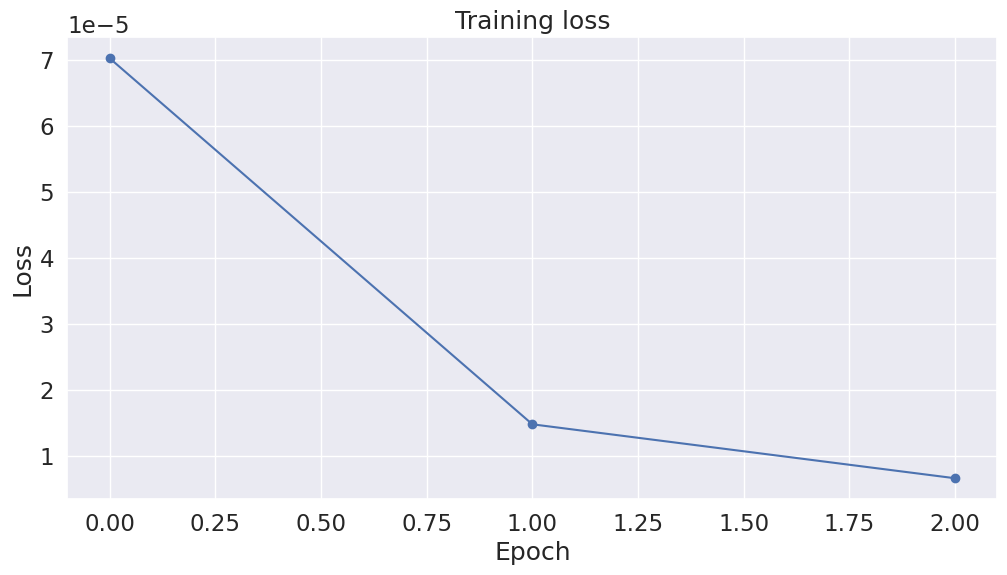

In [ ]:
drug_entities = get_entities('/content/drug_train_set.csv','/content/drug_test_set.csv') #CHANGE PATH
disease_entities = get_entities('/content/disease_train_set.csv','/content/disease_test_set.csv') #CHANGE PATH

======== Epoch 1/3 ========
Train Loss: 0.14719138534683654 Train Accuracy: 0.9497728898426323
Val Loss: 0.6442922826083202 Val Accuracy: 0.8808883647798742
======== Epoch 2/3 ========
Train Loss: 0.025720263951230202 Train Accuracy: 0.9895350500715308
Val Loss: 0.6666685668927319 Val Accuracy: 0.8855738993710693
======== Epoch 3/3 ========
Train Loss: 0.014739629714609855 Train Accuracy: 0.9930150214592276
Val Loss: 0.76712459438252 Val Accuracy: 0.8831682389937107


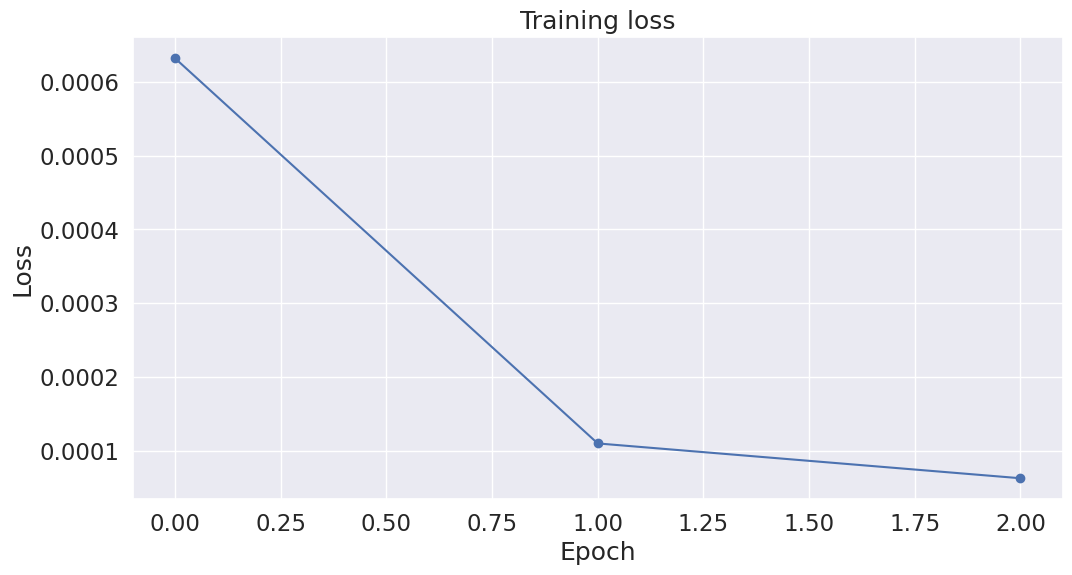

======== Epoch 1/3 ========
Train Loss: 0.2109636338133561 Train Accuracy: 0.9358245614035088
Val Loss: 0.16996140023693443 Val Accuracy: 0.9580555555555557
======== Epoch 2/3 ========
Train Loss: 0.03028715834217636 Train Accuracy: 0.986561403508772
Val Loss: 0.2212874546336631 Val Accuracy: 0.9549166666666669
======== Epoch 3/3 ========
Train Loss: 0.018038824494732052 Train Accuracy: 0.991811403508772
Val Loss: 0.23486492093652486 Val Accuracy: 0.9550208333333334


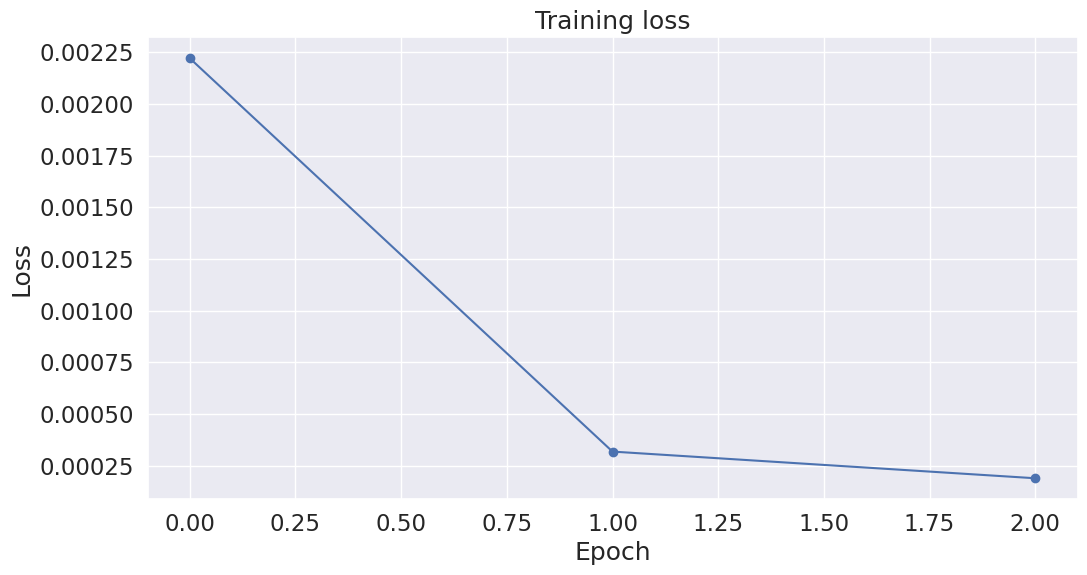

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [{'name': 'oseltamivir', 'start': 43, 'end': 54, 'label': 'B-Drug', 'cui': '', 'umls_label': ''}], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [{'name': 'ribavirin', 'start': 42, 'end': 51, 'label': 'B-Drug', 'cui': '', 'umls_label': ''}], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [{'name': 'yucatan', 'start

In [ ]:
ggp_entities = get_entities('/content/ggp_train_file.csv','/content/ggp_test_file.csv') #CHANGE PATH
cell_entities = get_entities('/content/cell_train_file.csv','/content/cell_test_file.csv') #CHANGE PATH

Group multiple words entities

In [ ]:
from numpy.ma.core import empty
list_entities1 = list( map(add, disease_entities, drug_entities) )
print(list_entities1)
list_entities2 = list( map(add, ggp_entities, cell_entities) )
list_entities = list( map(add, list_entities1, list_entities2) )
print(list_entities)

"""
enti = []
for entities in list_entities:
  entis = []
  for i in range(len(entities)):
    if(entities[i]['label'] != 'I-Disease'):
      entis.append(entities[i])
    if(entities[i]['label'] == 'I-Disease'):
      if entis:
        entis[-1]['name'] = entis[-1]['name'] + ' ' + entities[i]['name']
        entis[-1]['end'] = entities[i]['end']
      else:
        entities[i]['label'] = 'B-Disease'
        entis.append(entities[i])
  enti.append(entis)
"""

enti = []
for entities in list_entities:
  entis = []
  for i in range(len(entities)):
    if(entities[i]['label'] == 'B-Disease' or entities[i]['label'] == 'B-Drug' or entities[i]['label'] == 'B-Cell' or entities[i]['label'] == 'B-Gene_or_gene_product'):
      entis.append(entities[i])
    if(entities[i]['label'] == 'I-Disease' or entities[i]['label'] == 'I-Cell' or entities[i]['label'] == 'I-Gene_or_gene_product'):
      if entis:
        entis[-1]['name'] = entis[-1]['name'] + ' ' + entities[i]['name']
        entis[-1]['end'] = entities[i]['end']
      else:
        entities[i]['label'] = 'B-Disease'
        entis.append(entities[i])
  enti.append(entis)


[[], [], [], [{'name': 'respiratory', 'start': 8, 'end': 19, 'label': 'B-Disease', 'cui': '', 'umls_label': ''}, {'name': 'viral', 'start': 20, 'end': 25, 'label': 'I-Disease', 'cui': '', 'umls_label': ''}, {'name': 'infections', 'start': 26, 'end': 36, 'label': 'I-Disease', 'cui': '', 'umls_label': ''}, {'name': 'lower', 'start': 88, 'end': 93, 'label': 'B-Disease', 'cui': '', 'umls_label': ''}, {'name': 'respiratory', 'start': 94, 'end': 105, 'label': 'I-Disease', 'cui': '', 'umls_label': ''}, {'name': 'illnesses', 'start': 106, 'end': 115, 'label': 'I-Disease', 'cui': '', 'umls_label': ''}, {'name': 'respiratory', 'start': 123, 'end': 134, 'label': 'B-Disease', 'cui': '', 'umls_label': ''}, {'name': 'viral', 'start': 135, 'end': 140, 'label': 'I-Disease', 'cui': '', 'umls_label': ''}, {'name': 'infection', 'start': 141, 'end': 150, 'label': 'I-Disease', 'cui': '', 'umls_label': ''}, {'name': 'syncytial', 'start': 212, 'end': 221, 'label': 'I-Disease', 'cui': '', 'umls_label': ''}], 

In [ ]:
print(len(drug_entities))
print(len(disease_entities))
print(len(cell_entities))
print(len(ggp_entities))
print(len(list_entities))

1409
1409
1409
1409
1409


# **EL**

In [ ]:
nlp = spacy.load("en_core_sci_sm")

_config = {"linker_name": "umls"}
linker = UmlsEntityLinker(resolve_abbreviations=False)
nlp.add_pipe('scispacy_linker', config=_config)
c_s_el = []

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/tfidf_vectors_sparse.npz not found in cache, downloading to /tmp/tmph2huxs74
Finished download, copying /tmp/tmph2huxs74 to cache at /root/.scispacy/datasets/2b79923846fb52e62d686f2db846392575c8eb5b732d9d26cd3ca9378c622d40.87bd52d0f0ee055c1e455ef54ba45149d188552f07991b765da256a1b512ca0b.tfidf_vectors_sparse.npz
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/nmslib_index.bin not found in cache, downloading to /tmp/tmpif4ui7i0
Finished download, copying /tmp/tmpif4ui7i0 to cache at /root/.scispacy/datasets/7e8e091ec80370b87b1652f461eae9d926e543a403a69c1f0968f71157322c25.6d801a1e14867953e36258b0e19a23723ae84b0abd2a723bdd3574c3e0c873b4.nmslib_index.bin
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/tfidf_vectorizer.joblib not found in cache, downloading to /tmp/tmpnplfvlqf
Finished download, copying /tmp/tmpnplfvlqf to cache at /root/.scispacy/da

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.1.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.1.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/linkers/2023-04-23/umls/concept_aliases.json not found in cache, downloading to /tmp/tmpql4k1484
Finished download, copying /tmp/tmpql4k1484 to cache at /root/.scispacy/datasets/6238f505f56aca33290aab44097f67dd1b88880e3be6d6dcce65e56e9255b7d4.d7f77b1629001b40f1b1bc951f3a890ff2d516fb8fbae3111b236b31b33d6dcf.concept_aliases.json
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/kbs/2023-04-23/umls_2022_ab_cat0129.jsonl not found in cache, downloading to /tmp/tmpp_oki932
Finished download, copying /tmp/tmpp_oki932 to cache at /root/.scispacy/datasets/d5e593bc2d8adeee7754be423cd64f5d331ebf26272074a2575616be55697632.0660f30a60ad00fffd8bbf084a18eb3f462fd192ac5563bf50940fc32a850a3c.umls_2022_ab_cat0129.jsonl
https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/data/umls_semantic_type_tree.tsv not found in cache, downloading to /tmp/tmp7m8a1frv
Finished download, copying /tmp/tmp7m8a1frv to cache at /root/.scispacy/datasets/21a1012c53

In [ ]:
umls_types = ['T064','T065','T066','T069','T070','T071','T072','T073','T074','T075','T077','T078','T079','T080','T081','T082','T083','T089','T090','T091','T092','T093','T094','T095','T096','T098','T097','T099','T100','T102','T168','T169','T170','T171','T185','T196','T203','T204']
for ent in enti:
  for entt in ent:
    umls_ents = spacy.tokenizer.Span(nlp(entt['name']),0,len(nlp(entt['name'])))._.kb_ents
    if len(umls_ents) != 0:
      if(not(linker.kb.cui_to_entity[umls_ents[0][0]].types[0] in umls_types)):
        entt['cui'] = umls_ents[0][0]
        entt['umls_label'] = linker.kb.cui_to_entity[umls_ents[0][0]].canonical_name
        print('types',linker.kb.cui_to_entity[umls_ents[0][0]].types)
        cs_el = umls_ents[0][1]
        for i in range(1,len(umls_ents)):
          if(entt['name'] == linker.kb.cui_to_entity[umls_ents[i][0]].canonical_name):
            entt['cui'] = umls_ents[i][0]
            entt['umls_label'] = linker.kb.cui_to_entity[umls_ents[i][0]].canonical_name
            print('types',linker.kb.cui_to_entity[umls_ents[i][0]].types)
            cs_el = umls_ents[i][1]
          else:
            if(umls_ents[i][1] > umls_ents[i-1][1]):
              entt['cui'] = umls_ents[i][0]
              entt['umls_label'] = linker.kb.cui_to_entity[umls_ents[i][0]].canonical_name
              print('types',linker.kb.cui_to_entity[umls_ents[i][0]].types)
              cs_el = umls_ents[i][1]
    else:
      entt['umls_label'] = entt['name']
      cs_el = 0
    c_s_el.append(cs_el)
    print(entt['name'],entt['cui'],entt['umls_label'],entt['label'])
print(sum(c_s_el)/len(c_s_el))

types ['T047']
respiratory viral infections C0729531 Viral respiratory infection B-Disease
lower respiratory illnesses  lower respiratory illnesses B-Disease
respiratory viral infection syncytial  respiratory viral infection syncytial B-Disease
types ['T047']
respiratory viral infections C0729531 Viral respiratory infection B-Disease
influenza  influenza B-Disease
types ['T047']
avian flu C0016627 Influenza in Birds B-Disease
types ['T047']
h5n1 C0016627 Influenza in Birds B-Gene_or_gene_product
types ['T005']
anellovirus C1234164 Anelloviridae B-Disease
types ['T201']
types ['T169']
respiratory C0521346 respiratory B-Disease
types ['T005']
polyomaviruses C0032556 Polyomavirus B-Disease
torque teno virus  torque teno virus B-Disease
types ['T033']
severe C0205082 Severe (severity modifier) B-Disease
h1n1   B-Gene_or_gene_product
h1n1   B-Gene_or_gene_product
h1n1   B-Gene_or_gene_product
similarly  similarly B-Gene_or_gene_product
types ['T047']
h5n1 C0016627 Influenza in Birds B-Gene_

In [ ]:
entities_file = open('cord19_entities_file.json',"w")
n = entities_file.write(json.dumps(enti) + "\n")
#for entity in enti:
#  n = entities_file.write(str(entity) + "\n")
entities_file.close()